# Titanic
## Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

### 1. Imports

In [546]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from scipy.stats import skew
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

### 2. Get the data

In [547]:
data_path = '../inputs/train.csv'
train = pd.read_csv(data_path, index_col='PassengerId')

In [548]:
# first look
train.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [549]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [550]:
# Cabin is not only for first class
train[(train['Cabin'].isna() == False) & (train['Pclass'].isin([2, 3]))]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
67,1,2,"Nye, Mrs. (Elizabeth Ramell)",female,29.0,0,0,C.A. 29395,10.5000,F33,S
76,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S
124,1,2,"Webber, Miss. Susan",female,32.5,0,0,27267,13.0000,E101,S
129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0000,F2,S
184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S
194,1,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0000,F2,S


/home/caiomts/anaconda3/envs/infamous-ml/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

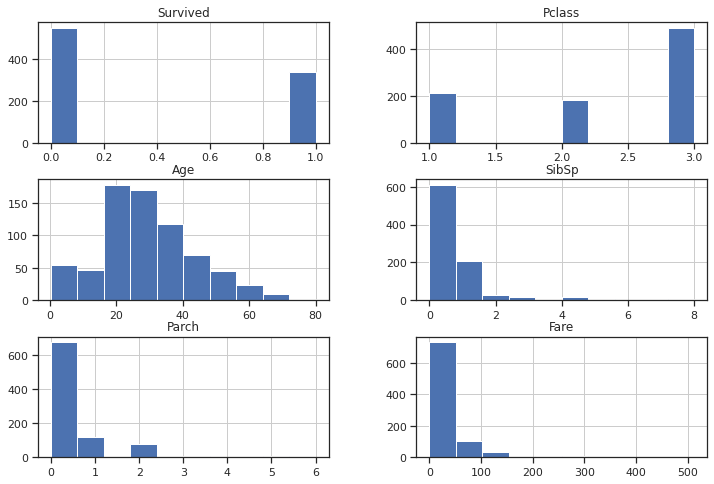

In [551]:
train.hist(figsize=(12, 8))

In [552]:
def split_variables(df):
    col_types = [df[col].dtype for col in df.columns]
    col_num = [True if col_types[i] != 'object' else False for i in range(len(col_types))]
    col_cat = [True if col_types[i] == 'object' else False for i in range(len(col_types))]
    return col_num, col_cat

In [553]:
cols_num, cols_cat = split_variables(train)

### 3. Exploratory Data Analysis (EDA)

In [554]:
# Making a copy
train_eda = train.copy()

#### 3.1. Numerical Variables

In [555]:
# Looking for correlations
corr = train_eda.corr()
corr.sort_values(by='Survived', ascending=False)

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500


<AxesSubplot:>

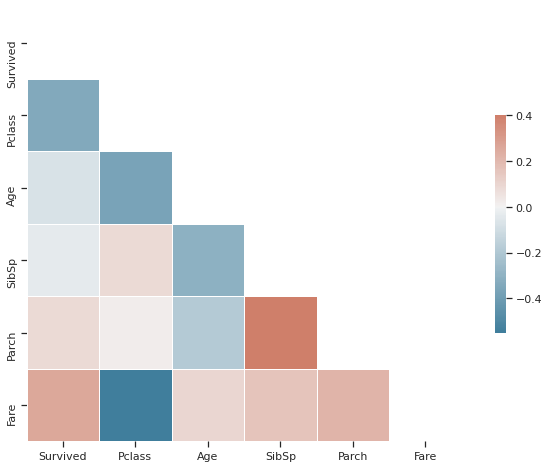

In [556]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [557]:
skewed = train_eda.loc[:, cols_num].apply(skew).sort_values(ascending=False)
skewed

Fare        4.779253
SibSp       3.689128
Parch       2.744487
Survived    0.477717
Pclass     -0.629486
Age              NaN
dtype: float64

In [558]:
# trying transformations
train_eda['Fare_log'] = np.log1p(train_eda['Fare'])
train_eda['SibSp_log'] = np.log1p(train_eda['SibSp'])
train_eda['Parch_log'] = np.log1p(train_eda['Parch'])

/home/caiomts/anaconda3/envs/infamous-ml/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>],
       [<AxesSubplot:title={'center':'Fare_log'}>,
        <AxesSubplot:title={'center':'SibSp_log'}>,
        <AxesSubplot:title={'center':'Parch_log'}>]], dtype=object)

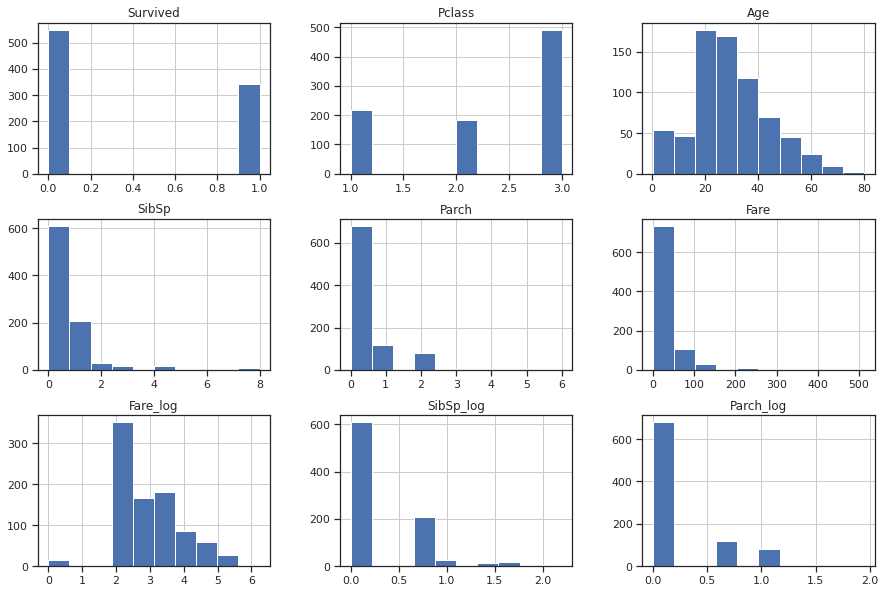

In [559]:
train_eda.hist(figsize=(15, 10))

In [560]:
train_eda.corr().sort_values(by='Survived', ascending=False)

,Survived,Pclass,Age,SibSp,Parch,Fare,Fare_log,SibSp_log,Parch_log
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.329862,0.029430,0.114999
Fare_log,0.329862,-0.661022,0.116495,0.318528,0.332186,0.787543,1.000000,0.375371,0.363261
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.787543,0.187671,0.238597
Parch_log,0.114999,-0.002530,-0.248052,0.464397,0.970328,0.238597,0.363261,0.473259,1.000000
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.332186,0.422113,0.970328
SibSp_log,0.029430,0.022021,-0.267173,0.936301,0.422113,0.187671,0.375371,1.000000,0.473259
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.318528,0.936301,0.464397
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.116495,-0.267173,-0.248052
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.661022,0.022021,-0.002530


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Parch', ylabel='SibSp'>

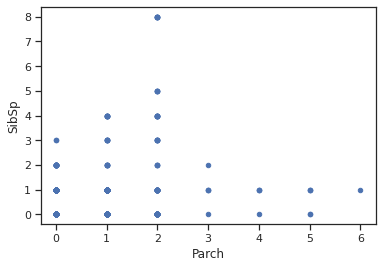

In [561]:
train_eda.plot(kind='scatter', x='Parch', y='SibSp')

In [584]:
train_eda['family'] = train_eda['Parch'] + train_eda['SibSp']
train_eda['family_log'] = np.log1p(train_eda['family'])
train_eda['Alone'] = (train_eda['Parch'] | train_eda['SibSp']).isin([0])

In [585]:
train_eda.corr().sort_values(by='Survived', ascending=False)

,Survived,Pclass,Age,SibSp,Parch,Fare,Fare_log,SibSp_log,Parch_log,family,family_log,Alone
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.329862,0.029430,0.114999,0.016639,0.107621,-0.203367
Fare_log,0.329862,-0.661022,0.116495,0.318528,0.332186,0.787543,1.000000,0.375371,0.363261,0.383658,0.451626,-0.478410
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.787543,0.187671,0.238597,0.217138,0.255685,-0.271832
Parch_log,0.114999,-0.002530,-0.248052,0.464397,0.970328,0.238597,0.363261,0.473259,1.000000,0.802159,0.833795,-0.651615
family_log,0.107621,-0.014144,-0.286287,0.796408,0.787769,0.255685,0.451626,0.863653,0.833795,0.937874,1.000000,-0.883201
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.332186,0.422113,0.970328,0.783111,0.787769,-0.583398
SibSp_log,0.029430,0.022021,-0.267173,0.936301,0.422113,0.187671,0.375371,1.000000,0.473259,0.850810,0.863653,-0.750416
family,0.016639,0.065997,-0.301914,0.890712,0.783111,0.217138,0.383658,0.850810,0.802159,1.000000,0.937874,-0.690922
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.318528,0.936301,0.464397,0.890712,0.796408,-0.584471
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.116495,-0.267173,-0.248052,-0.301914,-0.286287,0.198270


Fare_log, and Alone are good transformations (Drop: Parch, SibSb, fare) 

#### 3.2. Categorical Variables

In [564]:
train.loc[:, cols_cat].nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [565]:
train_eda['Cabin'].fillna(0, inplace=True)

In [566]:
train_eda['Cabin_'] = train_eda['Cabin'].apply(lambda x: str(x)[0])

In [567]:
pd.crosstab(train_eda['Survived'], train_eda['Cabin_'], normalize='columns')

Cabin_,0,A,B,C,D,E,F,G,T
Survived,,,,,,,,,
0,0.700146,0.533333,0.255319,0.40678,0.242424,0.25,0.384615,0.5,1.0
1,0.299854,0.466667,0.744681,0.59322,0.757576,0.75,0.615385,0.5,0.0


*Good Categorical Variable*

In [568]:
pd.crosstab(train_eda['Survived'], train_eda['Embarked'], normalize='columns')

Embarked,C,Q,S
Survived,,,
0,0.446429,0.61039,0.663043
1,0.553571,0.38961,0.336957


In [569]:
pd.crosstab(train_eda['Survived'], train_eda['Sex'], normalize='columns')

Sex,female,male
Survived,,
0,0.257962,0.811092
1,0.742038,0.188908


In [570]:
# Title
train_eda['Title'] = train_eda.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [571]:
train_eda['Title']

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
       ... 
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Name: Title, Length: 891, dtype: object

In [572]:
pd.crosstab(train_eda['Survived'], train_eda['Title'], normalize='columns')

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0,1.0,0.5,1.0,0.571429,1.0,0.0,0.5,0.425,0.302198,0.0,0.0,0.843327,0.208,0.0,1.0,0.0,0.0
1,0.0,0.5,0.0,0.428571,0.0,1.0,0.5,0.575,0.697802,1.0,1.0,0.156673,0.792,1.0,0.0,1.0,1.0


### 4. Prepare the data for ML Algorithms

In [626]:
# Missing Values
train.dropna(subset=['Embarked'], axis=0, inplace=True)

X = train.drop(['Survived'], axis=1)
y = train['Survived'].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Name      889 non-null    object 
 2   Sex       889 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Ticket    889 non-null    object 
 7   Fare      889 non-null    float64
 8   Cabin     202 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.4+ KB


#### 4.1. Data Cleaning

In [627]:
# drop attributes
X.drop(['Ticket'], axis=1, inplace=True)

# imputers
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='constant', fill_value=0)

# Split Attributes
num, cat = split_variables(X)

X_num = X.loc[:, num]
X_cat = X.loc[:, cat]

#fit
X_num_tr = imputer_num.fit_transform(X_num)
X_num_tr = pd.DataFrame(X_num_tr, columns=X_num.columns)

X_cat_tr = imputer_cat.fit_transform(X_cat)
X_cat_tr = pd.DataFrame(X_cat_tr, columns=X_cat.columns)

#### 4.2. Handling Text and Categorical Attributes 

In [628]:
# Cabin transformation

X_cat['Cabin'] = X.Cabin.apply(lambda x: str(x)[0])
X_cat['Name'] = X.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

<ipython-input-628-550435279d8c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat['Cabin'] = X.Cabin.apply(lambda x: str(x)[0])
<ipython-input-628-550435279d8c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat['Name'] = X.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())


In [611]:
X_cat.columns

Index(['Name', 'Sex', 'Cabin', 'Embarked'], dtype='object')

#### 4.3. Customer Transformation

In [629]:
Fare = 2

class logtransformation(BaseEstimator, TransformerMixin):
    def __init__(self):
        self
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X[:, Fare] = np.log1p(X[:, Fare])
        return X


In [602]:
X.columns == 'int64'

array([False, False, False, False, False, False, False, False, False])

#### 4.4. Transformation Pipeline (num)

In [630]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('logtransformation', logtransformation()),
    ('std_scale', StandardScaler())
])

X_num_pipe = num_pipeline.fit_transform(X_num)

In [631]:
X['Cabin'] = X['Cabin'].apply(lambda x: str(x)[0])
X['Name'] = X.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
X['Alone'] = (X['Parch'] | X['SibSp']).isin([0])
X.drop(['Parch', 'SibSp'], axis=1, inplace=True)

# Split Attributes
num, cat = split_variables(X)

X_num = X.loc[:, num]
X_cat = X.loc[:, cat]

# Set both types of attributes

num_att = X_num.columns
cat_att = X_cat.columns

full_pipe = ColumnTransformer([
    ('num', num_pipeline, num_att),
    ('cat', OneHotEncoder(), cat_att)
])


X_prepared = full_pipe.fit_transform(X)

In [625]:
num_att

Index(['Pclass', 'Name', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Alone'], dtype='object')

### 5. Select and Train a Model

#### Logit Regression

In [671]:
logit_model = LogisticRegression()
logit_model.fit(X_prepared, y)

LogisticRegression()

In [672]:
logit_preds = logit_model.predict(X_prepared)
logit_model.score(X_prepared, y)

0.8200224971878515

#### 5.1. Cross-Validation

In [634]:
def cross_valid_scores(model, X, y, scoring, cv):
    scores = cross_val_score(model, X, y,
                             scoring=scoring, cv=cv)
    return print(f'Scores: {scores}\nMean: {scores.mean()}\nsd: {scores.std()}')

In [675]:
cross_valid_scores(logit_model, X_prepared, y, 'accuracy', 10)

Scores: [0.76404494 0.82022472 0.78651685 0.85393258 0.83146067 0.80898876
 0.78651685 0.79775281 0.84269663 0.79545455]
Mean: 0.8087589376915221
sd: 0.026694970692384103


#### Bernoulli Naive Bayes

In [636]:
naive_model = BernoulliNB()
naive_model.fit(X_prepared, y)

BernoulliNB()

In [637]:
naive_preds = naive_model.predict(X_prepared)
naive_model.score(X_prepared, y)

0.7952755905511811

In [638]:
cross_valid_scores(naive_model, X_prepared, y, 'accuracy', 10)

Scores: [0.78651685 0.79775281 0.75280899 0.85393258 0.79775281 0.78651685
 0.78651685 0.76404494 0.80898876 0.78409091]
Mean: 0.7918922369765067
sd: 0.025807955190276156


#### Random Forest

In [639]:
randomf_model = RandomForestClassifier()
randomf_model.fit(X_prepared, y)

RandomForestClassifier()

In [640]:
randomf_preds = randomf_model.predict(X_prepared)
randomf_model.score(X_prepared, y)

0.984251968503937

In [674]:
cross_valid_scores(randomf_model, X_prepared, y, 'accuracy', 10)

Scores: [0.75280899 0.84269663 0.75280899 0.82022472 0.84269663 0.83146067
 0.79775281 0.76404494 0.86516854 0.84090909]
Mean: 0.8110572012257405
sd: 0.039363043373476014


### 6. Fine-tune the model

In [642]:
distributions = [{'n_estimators': np.arange(10, 200, 10),
                  'max_features': np.arange(2, 20, 2)
                 },
                 {'bootstrap': [False],
                  'n_estimators': np.arange(10, 200, 10),
                  'max_features': np.arange(2, 20, 2)
                 }]
clf = RandomizedSearchCV(randomf_model, distributions, random_state=0)
search = clf.fit(X_prepared, y)
search.best_params_

{'n_estimators': 170, 'max_features': 14, 'bootstrap': False}

In [643]:
search.best_estimator_

RandomForestClassifier(bootstrap=False, max_features=14, n_estimators=170)

In [644]:
search.cv_results_

{'mean_fit_time': array([0.28736043, 0.27901058, 0.3334353 , 0.25902076, 0.10862589,
        0.31946173, 0.01851192, 0.28279037, 0.01810327, 0.29150348]),
 'std_fit_time': array([0.00611795, 0.00471591, 0.00880966, 0.00908147, 0.00253999,
        0.00924446, 0.00075903, 0.0064359 , 0.00086833, 0.00431709]),
 'mean_score_time': array([0.01489563, 0.01340389, 0.01643825, 0.0125833 , 0.00660567,
        0.01469727, 0.00157614, 0.01531115, 0.00153975, 0.01638808]),
 'std_score_time': array([7.29342992e-04, 3.42528033e-04, 7.36156225e-04, 3.07911864e-04,
        1.17593341e-04, 1.26467103e-04, 1.54209565e-04, 1.77974421e-04,
        8.44444008e-05, 3.06195797e-04]),
 'param_n_estimators': masked_array(data=[170, 150, 190, 140, 70, 170, 10, 180, 10, 190],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[10, 12, 14, 12, 2, 14, 10, 6, 8, 4]

In [645]:
feat_importance = search.best_estimator_.feature_importances_
feat_importance

array([8.15470951e-02, 2.19007776e-01, 2.45831628e-01, 2.06127036e-02,
       9.18408365e-04, 4.78634965e-04, 2.69234979e-04, 1.91010780e-03,
       1.29203417e-04, 1.15319840e-05, 9.31189324e-04, 1.19146703e-02,
       9.85630747e-03, 4.44590874e-07, 0.00000000e+00, 1.44690895e-01,
       1.47918491e-02, 1.39289979e-05, 2.98506412e-03, 2.82875683e-04,
       1.43337757e-05, 7.40962162e-02, 8.54717301e-02, 2.62229994e-03,
       3.59721119e-03, 4.33342510e-03, 4.41884771e-03, 7.99500402e-03,
       1.48756396e-03, 9.51152474e-04, 1.62436790e-04, 2.87878183e-02,
       9.24296692e-03, 6.23999210e-03, 1.43954531e-02])

### 7. Evaluate the model on Test Set 

In [678]:
final_model = search_log.best_estimator_

In [658]:
path_test = '../inputs/test.csv'
test = pd.read_csv(path_test, index_col='PassengerId')

In [659]:
# drop attributes
test.drop(['Ticket'], axis=1, inplace=True)

test['Cabin'] = test['Cabin'].apply(lambda x: str(x)[0])
test['Name'] = test.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
test['Name'] = test.Name.apply(lambda x: 'Ms' if x == 'Dona' else x)
test['Alone'] = (test['Parch'] | test['SibSp']).isin([0])
test.drop(['Parch', 'SibSp'], axis=1, inplace=True)

test_prepared = full_pipe.transform(test)

In [679]:
test_preds = final_model.predict(test_prepared)

In [680]:
test_final_df = pd.DataFrame(np.c_[test.index.values, test_preds], columns=['PassengerId', 'Survived'])

In [681]:
test_final_df.to_csv('../submission.csv', index=False)

In [ ]:
test_preds = logit_model.predict(test_prepared)

In [ ]:
test_final_df = pd.DataFrame(np.c_[test.index.values, test_preds], columns=['PassengerId', 'Survived'])

In [ ]:
test_final_df.to_csv('../submission3.csv', index=False)